In [7]:
from sklearn import tree
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_score, LeaveOneOut, train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn import neighbors, metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import copy
from matplotlib import cm, colors
import cv2
import warnings
import collections


# Takes a 2D numpy array as input (i.e. a numpy representation of an image)
# Different from tree since the empty ratio is different. Could implement a generic
# solution down the line
def processNextHouseImage(image): 
    objectwidth = 100
    objectheight = 100
    xspacing = 116
    yspacing = 300
    xstart = 293
    ystart = 445
    xend = 1730
    yend = 1770
    powderthickness = 80
    objectCoordinates = [[x, x+objectwidth, y, y+objectheight] for y in reversed(range(
        ystart, yend, objectheight + yspacing)) for x in range(xstart, xend, xspacing + objectwidth)]
    # Rest NYI

# Returns a list of images of each object, with the background filtered out
def processNextTreeImage(image):
    objectwidth = 83
    objectheight = 122
    xspacing = 133
    yspacing = 270
    xstart = 293
    ystart = 268
    xend = 1730
    yend = 1770

    # objectinfo = pd.read_csv('Parameters.csv', names=["Object", "P", "S", "H", "Porosity", "Label"])

    objectCoordinates = [[x, x+objectwidth, y, y+objectheight] for y in reversed(range(
        ystart, yend, objectheight + yspacing)) for x in range(xstart, xend, xspacing + objectwidth)]
    # coorddf = pd.DataFrame(objectCoordinates, columns=['xstart', 'xend', 'ystart', 'yend'])
    # objectinfo = coorddf.join(objectinfo)

    objects = np.full((len(objectCoordinates), objectheight, objectwidth), np.nan)

    for index, object in objectCoordinates.iterrows():
        objects[index] = image[object.ystart:object.yend, object.xstart:object.xend]

    # for object in objects:
    #     object[~mask] = np.nan

    return objects

class backgroundRemover:
    def __init__(self, mask):
        self.mask = mask

    def removeBackground(self, images):
        rtn = np.copy(images)
        for object in rtn:
            object[~self.mask] = np.nan
        return rtn

# Conducts preprocessing. OldObjectLayers is a list of objects, with each object being a 3d numpy array

class preprocessor:
    def __init__(self, type):
        self.type = type

    def preprocess(self, newObjectLayers):
        # layerIndex = self.currentLayer
        returnValue = []
        for index, object in enumerate(newObjectLayers):
            if self.type == 'scatter' or self.type == 'spatstat':
                object = np.copy(object)
                xs = np.array(object, copy=True, dtype=np.float32)
                # self.accumulatedLayers[index][layerIndex] = xs
                returnValue.append(xs)
            elif self.type == 'moran':
                # Todo: consider revising and not doing on a layer-by-layer basis?
                xs = np.array(object, copy=True, dtype=np.float32)
                avg = np.nanmean(xs)
                stddev = np.nanstd(xs)
                xs = (xs - avg) / stddev
                # self.accumulatedLayers[index][layerIndex] = xs
                returnValue.append(xs)
        return returnValue

class outlierCalculator:
    # Behöver kila, när jag är tillbaka:
    def __init__(self, type, neighbourhoodDistance, windowSize, z):
        self.type = type
        self.nbhd = neighbourhoodDistance
        self.ws = windowSize
        self.z = z
        self.currentLayer = -1
        self.init = False

    def reset(self):
        self.init = False
        self.currentLayer = -1

    def calculate(self, newObjectLayers):
        self.currentLayer += 1
        outlierValues = []
        if not self.init:
            self.init = True
            self.accumulatedLayers = []
        for index, objectLayer in enumerate(newObjectLayers):
            # Step 1: calculate neighbourhood
            object = np.copy(objectLayer)
            neighbourkernel = np.ones((self.nbhd, self.nbhd)) / self.nbhd**2
            flatNeighbourhood = np.array(cv2.filter2D(src=objectLayer, ddepth=-1, kernel=neighbourkernel))
            if(len(self.accumulatedLayers) < index+1):
                xSize = object.shape[0]
                ySize = object.shape[1]
                self.accumulatedLayers.append(np.full((self.z, xSize, ySize), np.nan))
            self.accumulatedLayers[index][self.currentLayer] = flatNeighbourhood

            if(self.currentLayer+1 < self.ws):
                print("no result yet")
                continue
            step1 = self.accumulatedLayers[index][self.currentLayer-(self.ws-1):self.currentLayer+1]

            step2 = np.sum(step1, axis=0)
            neighbourhoodValues = step2 / self.ws
            # Här har vi tre saker att hålla koll på:
            # - Nästa lager
            # - Tidigare lager som del av beräkningen
            # - Tidigare lagers neighbourhoodvalues (eller, varför?)
            # Vi vill returnera fler neighbourhoodvalues baserat på lagret som kom in... skit i tidigare, de poolas längre ned.

            # Step 2: calculate outlier
            ys = neighbourhoodValues
            xs = object
            filter = np.logical_and(np.isfinite(xs), np.isfinite(ys))

            # plt.imshow(xs[0])
            # plt.figure()
            # plt.imshow(xs[0])
            # plt.figure()
            # if(index == 58):
            #     plt.imshow(xs[0])
            #     plt.figure()
            #     plt.imshow(ys[0])
            #     plt.figure()
            #     plt.imshow(filter[0])
            #     plt.figure()
            #     print(len(np.unique(filter)))
            numberOfFilterValues = len(np.unique(filter))
            assert numberOfFilterValues == 2, f"Expected filter to have two values, got: {numberOfFilterValues}"
            # print("index is:", index)
            if type == 'spatstat':
                outliers = xs - ys
                #Todo: Is this correct? Moran seems off
                avg = np.mean(outliers[filter])
                std = np.std(outliers[filter])
                outliers = (outliers - avg) / std
                outlierValues.append(outliers)
            elif self.type == 'scatter' or self.type == 'spatstat':
                with warnings.catch_warnings():
                    line = np.polyfit(xs[filter].flatten(), ys[filter].flatten(), 1)
                    p = np.poly1d(line)
                    outlierValues.append(p(xs) - ys)
                assert(xs.shape == p(ys).shape)
            assert(len(np.unique(outlierValues[index])) > 1)
            assert(len(np.unique(np.isfinite(outlierValues[index]))) == 2)
        return outlierValues

class encoder:
    def __init__(self, noOfBins, minval=0, maxval=0):
        self.min = minval
        self.max = maxval
        self.buckets = noOfBins
        self.noOfLayers = 0
    
    # Vad returnerar den här? Ett histogram för hela objektet hittils.
    def encode(self, outlierobjects):
        self.noOfLayers += 1
        numberOfObjects = len(outlierobjects)
        # If not locked, store all values and recalculate histogram
        # If locked, store only histogramstuff
        # What do we emit here? I'd say we emit the complete histogram
        # Why raw? What I doing?
        returnData = np.zeros((numberOfObjects, self.buckets))
        for index in range(0, numberOfObjects):
            xs = outlierobjects[index]
            filter = np.isfinite(xs)
            hist, edges = np.histogram(xs[filter], bins=self.buckets, range=(self.min, self.max), density=True)
            returnData[index] = hist

        return returnData
    
class accumulator:
    def __init__(self, windowSize, windowOffset):
        self.ws = windowSize
        self.wo = windowOffset
        self.data = collections.deque(maxlen=windowSize)
        self.currentIndex = 0

    def reset(self):
        self.data = collections.deque(maxlen=self.ws)
        self.currentIndex = 0
    
    def next(self, nextData):
        self.data.append(nextData)
        self.currentIndex += 1
        if (self.currentIndex % self.wo) == 0:
            return np.sum(self.data, axis=0)
        else:
            return False
        
    

def classify(Xtrain, Ytrain, Xtest, Ytest, n_neighbors, ):
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights="uniform", n_jobs=-1)
    scaler = StandardScaler()
    clf = Pipeline([('scaler', scaler), ('classifier', clf)])
    cvs = cross_val_score(clf, Xtrain, Ytrain, cv=5, scoring='roc_auc', n_jobs=-1)
    clf.fit(Xtrain, Ytrain)
    yfit = clf.predict_proba(Xtest)[:,1]
    return cvs.mean(), metrics.roc_auc_score(Ytest, yfit)

In [8]:
import pathlib

# Returns a list of 
def readRawTreeImages():
    objectwidth = 83
    objectheight = 122
    xspacing = 133
    yspacing = 270
    xstart = 293
    ystart = 268
    xend = 1730
    yend = 1770
    endlayer = 187

    paths = pathlib.Path('./OT data 80 um/int').glob('*.tif')
    paths_sorted = [x for x in paths]
    paths_sorted.sort()
    block = np.array([np.array(plt.imread(path)) for path in paths_sorted])
    integrals = block[0:endlayer]

    del paths_sorted

    objectCoordinates = [[x, x+objectwidth, y, y+objectheight] for y in reversed(range(
        ystart, yend, objectheight + yspacing)) for x in range(xstart, xend, xspacing + objectwidth)]
    coorddf = pd.DataFrame(objectCoordinates, columns=['xstart', 'xend', 'ystart', 'yend'])

    objects = np.full((len(coorddf), endlayer, objectheight, objectwidth), np.nan)

    for index, object in coorddf.iterrows():
        objects[index] = integrals[:, object.ystart:object.yend, object.xstart:object.xend]
    
    return objects

# objects är en 4d numpy array
def makeMask(objects, emptyRatio):
    aggregate = np.sum(objects, axis=(0,1))
    limit = np.percentile(aggregate, emptyRatio)
    print("The limit is ", limit, "")
    mask = aggregate >= limit
    return mask

def getLabels():
    objectinfo = pd.read_csv('Parameters.csv', names=["Object", "P", "S", "H", "Porosity", "Label"])
    objectinfo.replace('GOOD', 0, inplace=True)
    objectinfo.replace('LOF', 1, inplace=True)
    return np.array(objectinfo.loc[:,"Label"])

The limit is  57090884.0 
(26, 83)
1
(26, 83)
2
(26, 83)
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187


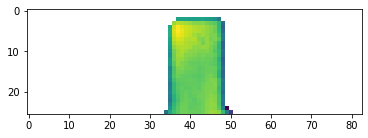

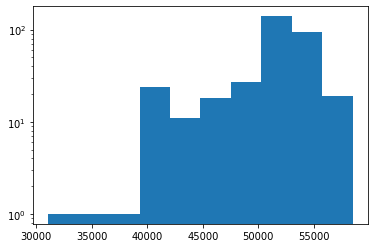

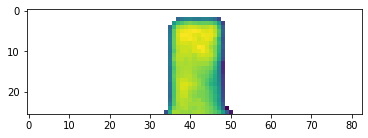

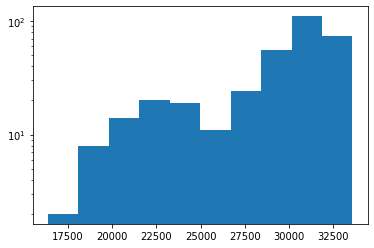

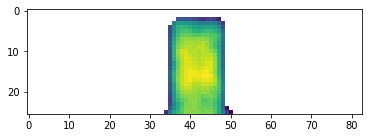

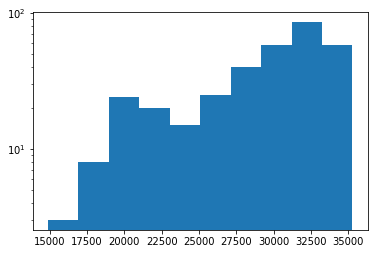

<Figure size 432x288 with 0 Axes>

In [9]:
from sklearn.model_selection import train_test_split
# Training cell

# High level picture
# We can batch prepare

# Start with the training
emptyRatio = 47
objectwidth = 83
objectheight = 122
layers = 187

odtype = 'scatter'
neighbourhoodDistance = 3
neighbourhoodZ = 1
windowSize = layers
windowOffset = layers
noOfBins = 20
n_neighbors = 3
# Fraction, 0-1
test_size = 0.4
hsegments = [0,26,50,74,98,122]
mask = np.zeros((objectwidth, objectheight))

allImages = readRawTreeImages()
mask = makeMask(allImages, emptyRatio)
allImages = allImages[(np.arange(len(allImages))!=20) & (np.arange(len(allImages))!=27)]
labels = getLabels()
labels = np.int16(labels[(np.arange(len(labels))!=20) & (np.arange(len(labels))!=27)])
X_train, X_test, y_train, y_test = train_test_split(allImages, labels, test_size=test_size)
X_train = allImages
y_train = labels
# trainObjects = allImages[[1,2,3,5,6,8,9,11,12,14,15,17,18,21,23,24,26], :, :, :]
# testObjects = allImages[[0,4,7,10,13,16,19,22,25], :, :, :]

# testMask = np.array([1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0])
# trainMask = testMask == 0
# trainMask[20] = False
# trainMask[27] = False
# ytrain = np.extract(trainMask, labels)
# ytest = np.extract(testMask, labels)

# Todo: Uncomment this line
# mask = makeMask(X_train, emptyRatio)

bgr = backgroundRemover(mask)
p1 = preprocessor(odtype)
oc1 = outlierCalculator(odtype, neighbourhoodDistance, neighbourhoodZ, layers)
a1 = accumulator(windowSize, windowOffset)


# Hur skapar vi masken? Vad är lättast?
# Dela inläsningen i två steg: en som bara delar, en som tar bort bakgrund. Skicka mask som input till dess constructor


allTrainingHists = []

# images är en lista av bildstackar?
# hur gör vi splitten här?
# - per föremål
# - per segment
# - per både våg- och horizontella segment
# Med all sannolikhet kommer vi ändra det senare, eller fokusera på att lära mellan geometrier
# lägst effort: lägg åt sidan 28*0.33 objekt som inte är med för att ha en prototyp uppe
# högst intresse: använd alla trädbilder för träning, använd alla husbilder för utvärdering, sätt automatisk gräns för
# bakgrund mha typ clustering
# medelväg: behandla bakgrundseliminering utanför streamingapproachen
# OK, steg 1: enbart träd. Ta 0.33 av dem och bara sätt åt sidan. Välj vilka själv. Så images är en lista av bilder...

# Ändra indexering ifrån [objektnummber, lager, x, y] till [lager, objektnummer, x, y]
def makesegments(image, hsegments):
    segments = []
    for obimg in image:
        for i in range(len(hsegments)-1):
            segments.append(obimg[hsegments[i]:hsegments[i+1],:])
    return segments

trainObjects = np.moveaxis(X_train, 1, 0)
testObjects = np.moveaxis(X_test, 1, 0)

allOcvals = []
allPresValues = []
i = 0
for image in trainObjects:
    # Ta bilden, omvandla till en array av bilder (en bild per obj)
    # Vilken struktur behöver preprocess? Lista med numpy array
    # image är 26x122x83
    # segments ska vara (26*5)x122x83
    noback = bgr.removeBackground(image)
    segments = makesegments(noback, hsegments)
    pres = p1.preprocess(segments)
    allPresValues.append(pres)
    # plt.hist(trainoutliers[0][1].flatten(), bins=bincount, range=(minval, maxval))
    if(i == 0 or i == 1 or i == 2):
        print(np.shape(pres[0]))
        plt.imshow(pres[0])
        plt.figure()
        plt.hist(pres[0].flatten())
        plt.yscale('log')
        plt.figure()
    i +=1 
    print(i)
    ocvals = oc1.calculate(pres)
    allOcvals.append(ocvals)

# ocVals: List[layers][objects][matrix]

ocmin = np.nanmin(np.concatenate([np.concatenate([o.flatten() for o in oo]) for oo in allOcvals]))
ocmax = np.nanmax(np.concatenate([np.concatenate([o.flatten() for o in oo]) for oo in allOcvals]))
e1 = encoder(noOfBins, ocmin, ocmax)

for ocvals in allOcvals:
    if len(ocvals) > 0:
        # Print a chart here
        hists = e1.encode(ocvals)
        accs = a1.next(hists)
        if type(accs) is np.ndarray:
            for acc in accs:
                allTrainingHists.append(acc)

(187, 130)


/Users/erik/Git/thesis/thesis-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:2007: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


<Figure size 432x288 with 0 Axes>

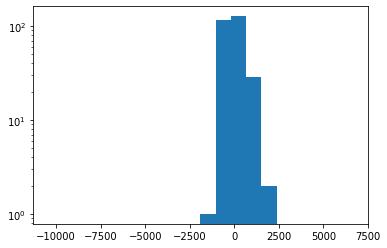

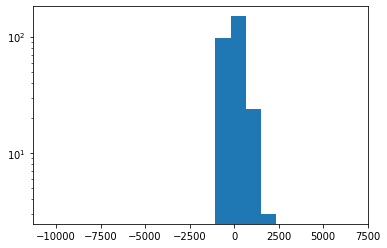

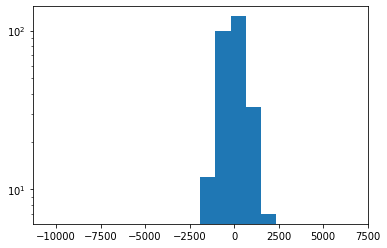

<Figure size 432x288 with 0 Axes>

In [20]:
plt.hist(allOcvals[1][0].flatten(), bins=noOfBins, range=(ocmin, ocmax))
plt.yscale('log')
plt.figure()
plt.hist(allOcvals[30][0].flatten(), bins=noOfBins, range=(ocmin, ocmax))
plt.yscale('log')
plt.figure()
plt.hist(allOcvals[31][0].flatten(), bins=noOfBins, range=(ocmin, ocmax))
plt.yscale('log')
plt.figure()

In [43]:
np.shape(pres[0])

(122, 83)

(array([  42.,  140.,  206.,  371., 1298., 1734., 1115.,  328.,  109.,
          24.]),
 array([12709. , 15703.1, 18697.2, 21691.3, 24685.4, 27679.5, 30673.6,
        33667.7, 36661.8, 39655.9, 42650. ], dtype=float32),
 <BarContainer object of 10 artists>)

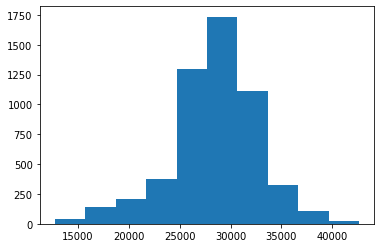

In [44]:
plt.hist(pres[0].flatten())

In [22]:
repetitions = len(allTrainingHists) / len(y_train)
knn = neighbors.KNeighborsClassifier(n_neighbors, weights="uniform", n_jobs=-1)
scaler = StandardScaler()
clf = Pipeline([('scaler', scaler), ('classifier', knn)])
ytrain2 = np.tile(y_train.astype('int'), [np.int32(repetitions)])
clf.fit(allTrainingHists, ytrain2)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', KNeighborsClassifier(n_jobs=-1, n_neighbors=3))])

0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.4375
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5


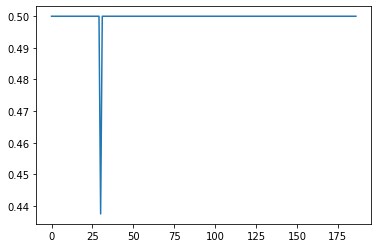

In [23]:
# Testing cell
from sklearn.metrics import f1_score, roc_auc_score
oc1.reset()
a1.reset()
y_test = y_test.astype('int')

testx = []
predictions = []
letsPrint = False
for image in testObjects:
    # Start of timing
    noback = bgr.removeBackground(image)
    pres = p1.preprocess(noback)
    ocvals = oc1.calculate(pres)
    if len(ocvals) > 0:
        if(letsPrint):
            plt.imshow(image[0])
            plt.title("background 0")
            plt.figure()
            plt.imshow(image[1])
            plt.title("background 1")
            plt.figure()
            plt.imshow(noback[0])
            plt.title("nobackground 0")
            plt.figure()
            plt.imshow(noback[1])
            plt.title("nobackground 1")
            plt.figure()
            plt.imshow(pres[0])
            plt.title("pres 0")
            plt.figure()
            plt.imshow(pres[1])
            plt.title("pres 1")
            plt.figure()
            plt.imshow(ocvals[0])
            plt.title("ocvals 0")
            plt.figure()
            plt.imshow(ocvals[1])
            plt.title("ocvals 1")
            plt.figure()
            plt.hist(ocvals[0].flatten(), bins=noOfBins, range=(ocmin, ocmax))
            plt.yscale('log')
            plt.figure()
            plt.hist(ocvals[1].flatten(), bins=noOfBins, range=(ocmin, ocmax))
            plt.yscale('log')
            plt.figure()
            break
        hists = e1.encode(ocvals)
        pred = clf.predict_proba(hists)[:,1]
        # End of timing
        testx.append(hists)
        predictions.append(pred)

# investigate accuracy etc here. Potentially batch it based on layer
ysvalue = []
for index, o in enumerate(predictions):
    print(roc_auc_score(y_test, o))
    ysvalue.append(roc_auc_score(y_test, o))
plt.plot(np.arange(0, len(ysvalue)), ysvalue)

In [19]:
print(predictions)

[array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.